# mmWave MIMO channel design

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 0, 'SNRdB')

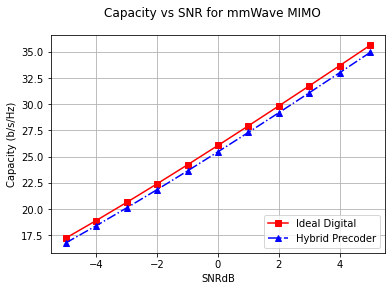

In [ ]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl
import matplotlib.pyplot as plt
import MIMO

# simulation parameters
t = 32; r = 32;
numRF = 6;
G = 64; # Number of angles in the dictionary
L = 8;  # number of multipaths
Ns = 6; # number of symbols
ITER = 100;

# Initializations
SNRdB = np.arange(-5,6,1);
C_HYB = np.zeros(len(SNRdB)); # Hybrid combiner capacity
C_MIMO = np.zeros(len(SNRdB)); # Ideal combiner capacity; MIMO combiner is ideal

# G-quantized Txarray response matrix
A_T = MIMO.ArrayDictionary(G,t);
A_R = MIMO.ArrayDictionary(G,r);

for ix in range(ITER):
    print(ix);

    # Channel generation
    tax = np.random.choice(G, L, replace=False);
    # np.random.choice Generates a random sample from a given 1-D array without replacement
    rax = np.random.choice(G, L, replace=False);
    # Generate channel gains for L multipath components
    chGain = 1/np.sqrt(2)*(nr.normal(0,1,L)+1j*nr.normal(0,1,L));
    A_T_genie = A_T[:, tax]; # Transmitter side array response vector
    # assuming perfect knowledge of angles of arrival
    A_R_genie = A_R[:, rax];# Transmitter side array response vector
    # assuming perfect knowledge of angles of arrival
    # Generate the H matrix
    H = np.sqrt(t*r/L)*nl.multi_dot([A_R_genie,np.diag(chGain),MIMO.H(A_T_genie)]);
    # Genie is the ideal case when the Angles of Arr and Depart are perfectly known
    U,S,VH = nl.svd(H, full_matrices = True);

    V = MIMO.H(VH); # ideal BB precoder
    Fopt = V[:,0:Ns]; # Ideal BB precoder is of size Nrf*Ns
    # FBB and FRF found after applying SOMP
    FBB, FRF = MIMO.SOMP(Fopt, A_T, np.identity(t), numRF);
    FBB_NORM = FBB*np.sqrt(Ns)/nl.norm(np.matmul(FRF,FBB));
    for cx in range(len(SNRdB)):
      npow = 10**(-SNRdB[cx]/10);
      mmseINV = nl.inv(MIMO.AHA(np.matmul(H,Fopt)) + npow*Ns*np.identity(Ns));
      Wmmse_opt = nl.multi_dot([H, Fopt, mmseINV]);
      C_MIMO[cx] = C_MIMO[cx] + MIMO.mimo_capacity(nl.multi_dot([MIMO.H(Wmmse_opt),H,Fopt]), 1/Ns*np.identity(Ns), npow*MIMO.AHA(Wmmse_opt));
      HFp = nl.multi_dot([H,FRF,FBB_NORM]);
      Ryy = 1/Ns*MIMO.AAH(HFp) + npow*np.identity(r);
      Wmmse_Hyb = np.matmul(HFp, nl.inv(MIMO.AHA(HFp) + npow*Ns*np.identity(Ns)));
      WBB, WRF = MIMO.SOMP(Wmmse_Hyb, A_R, Ryy, numRF);
      C_HYB[cx] = C_HYB[cx] + MIMO.mimo_capacity(nl.multi_dot([MIMO.H(WBB), MIMO.H(WRF), H, FRF, FBB_NORM]), 1/Ns*np.identity(Ns), npow*MIMO.AHA(np.matmul(WRF,WBB)));


C_MIMO = C_MIMO/ITER; C_HYB = C_HYB/ITER;
plt.plot(SNRdB, C_MIMO,'r-s');
plt.plot(SNRdB, C_HYB,'b^-.');
plt.grid(1,which='both')
plt.legend(["Ideal Digital", "Hybrid Precoder"], loc ="lower right");
plt.suptitle('Capacity vs SNR for mmWave MIMO')
plt.ylabel('Capacity (b/s/Hz)')
plt.xlabel('SNRdB')